#### Introduction - Plan for the notebook.

Reason for choosing this dataset: This dataset contains missing values, categorical values and binary label. It contains appropriate features and instance size. Census data are very interesting and good to practice machine learning, it's also one of the easiest to start learning and building the foundations for machine learning practice. 

Notebook contains: 
1. loading packages and dataset: I've loaded directly from uci package instead of downloading the dataset to try a new approach. 
2. EDA: Basic understandings of structure of dataset, exploration of data type and nature of each feature. 
3. Feature Selection/Transformation: I'll work with the assumptions of Logistic Regression (described further below)
4. Building Preprocessing Pipeline: Build an actual pipeline to transform dataset to be suitable for Logistic regression using the explorations done in step 2 and 3. 
5. Building Model & Evaluation

Assumptions of Logistic Regression: 
1. Label have to be Binary. 
2. Instances have to be independent. 
3. No multicollinearity, meaning features cannot be highly correlated. 
4. Features have to be linearly related with log odds of label.
5. Need Large Sample Size (rule of thummb: 10-15 times the number of features)


Note: 
In streamlit, be ready to show different cases. 
Check for different models. 
Check for coefficients to check which features will perform what. 
Confusion Metrics. 


#### Loading Packages and Dataset

In [2]:
from ucimlrepo import fetch_ucirepo
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [5]:

adult = fetch_ucirepo(id = 2)

X = adult.data.features
y = adult.data.targets

# I just copied this stright from uci website :) but it's easy to do read_csv and splitting to X and y tho.

#### Exploratory Data Analysis (EDA)

In [ ]:
print(X.shape, y.shape)

(48842, 14) (48842, 1)


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


Interpretation: There's columns with missing values, as well as many object columns. 
Need to clean and transform. 

In [ ]:
y.value_counts()

# Need to remove . at the end. 

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [6]:
y['income'] = y['income'].str.strip('.')
y.value_counts()

income
<=50K     37155
>50K      11687
Name: count, dtype: int64

In [7]:
#Turning y into binary. 
y['income'] = (y['income'] == '>50K').astype(int)

In [ ]:
X.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64

Interpretation: workclass and occupations are having ~960 missing rows and native-country ~270 missing rows. 

Both of them are similar columns about jobs, categorical data. I want to look a little into it before imputing them. 

In [ ]:
X.workclass.value_counts()

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [13]:
int_colnames

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

There's a ? column. I'm assuming it's missing value as well. 
Gotta check for all columns at this point...

In [8]:
object_colnames = X.select_dtypes(include = 'O').columns
int_colnames = X.select_dtypes(include = 'int64').columns

for k in object_colnames:
    print(X[k].value_counts(), '\n')

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64 

education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64 

marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64 

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial

Note: 
Since I don't know a better way to check, I thought I would just put it in a loop and check it with 
a scrollable format. It's doing things manually, but considering the shape of the dataset, it's not too much.

I'll also just do basic understanding of dataset's structure manually here. 

Interpretation: There's '?' in workclass, occupations, and native country. All three are columns with missing 
values. 

Next, some features like workclass are very imbalanced. 

In [9]:
#Turning '?' into missing values.
X = X.replace('?', np.nan)
X.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

Interpretation: Both the count of NA and 'workclass' and 'occupation' is very similar..
Since the missing values are around 5.7% of dataset, I'm going to use mode to impute.
It is most straightforward and won't have much impact on model.

#### Features Selection/Transformation

In [10]:
# Imputing Missing Values with Mode
X[object_colnames] = SimpleImputer(strategy='most_frequent').fit_transform(X[object_colnames])

In [11]:
# Setting Variables for Encoding
ordinal_object = X[['education']]
onehot_object = X.loc[:, object_colnames.drop('education')]
ordinal_order = [['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th','HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']]

In [ ]:
#Ordinal Encoder for Education
encoder = OrdinalEncoder(
        categories= ordinal_order,
        handle_unknown='use_encoded_value',
        unknown_value=-1
)
X[['education']]  = encoder.fit_transform(ordinal_object)

In [ ]:
#Copying Dataset before One-Hot Encoding.
X_copy = X.copy()

In [ ]:
#One Hot Encoder for Non-Ordinal Object Column 
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot_array = onehot.fit_transform(onehot_object)
new_arr=[]
for x in onehot_array:
    arr=[]
    for value in x:
        value=int(value)
        arr.append(value)

    new_arr.append(arr)
onehot_array = new_arr

onehot_df = pd.DataFrame(onehot_array, columns=onehot.get_feature_names_out(onehot_object.columns))
X.drop(columns=onehot_object.columns, inplace=True)
X = pd.concat([X,onehot_df], axis = 1)



In [ ]:
X


,age,fnlwgt,education,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,12.0,13,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,12.0,13,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,8.0,9,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,6.0,7,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,12.0,13,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,12.0,13,0,0,36,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48838,64,321403,8.0,9,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,38,374983,12.0,13,0,0,50,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48840,44,83891,12.0,13,5455,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Interpretation: the ordinay encoded education column is always 1 less than education number. 

In [ ]:
diff = (X['education-num'] - 1) - X['education']
if (diff == 0).all():
    print("They're same.")

They're same.


Interpretation: They are same so it's redundant, I'll drop the education column. 

In [ ]:
# Dropping education column.
X.drop(columns = 'education', inplace = True)

**Checking for Assumptions of Logsitic Regression**

1. Binary Label: Check. 
2. Independence of Observation: I don't think it's accurately possible to check this here, need to be done in data collection stage. Check.
3. No Multicollinearity: Need to check. 
4. Linearity with Log Odds: Need to check.
5. Large Sample Size: Check. 

Note: I had wanted to try working with assumptions, even if I don't know how to do proper follow up. 

In [ ]:
corr = X.corr().abs().unstack()
corr[(corr > 0.80) & (corr < 1)]

marital-status_Married-civ-spouse  relationship_Husband                 0.893676
relationship_Husband               marital-status_Married-civ-spouse    0.893676
sex_Female                         sex_Male                             1.000000
sex_Male                           sex_Female                           1.000000
dtype: float64

Interpretation: There's only two pairs that are highly correlated out of 89 features.
I think this is acceptable..
Check.

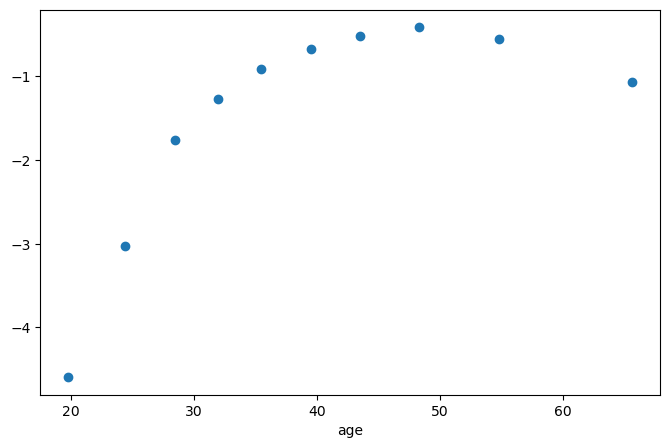

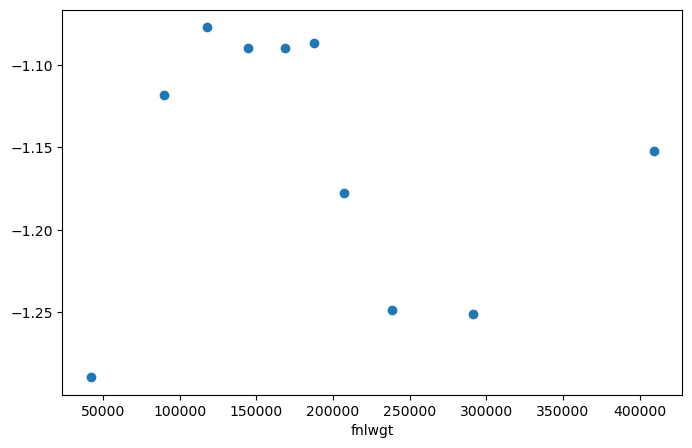

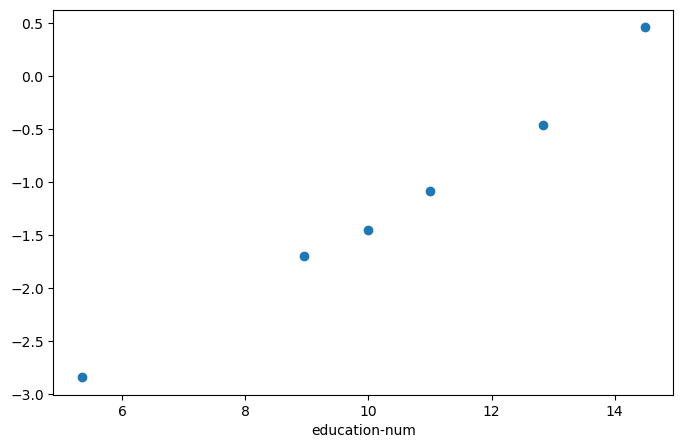

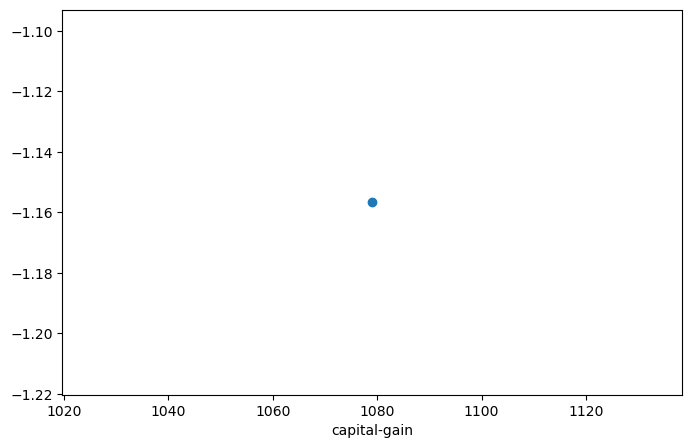

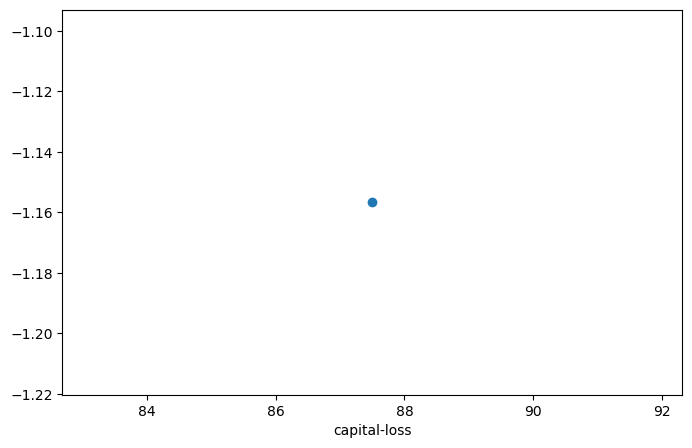

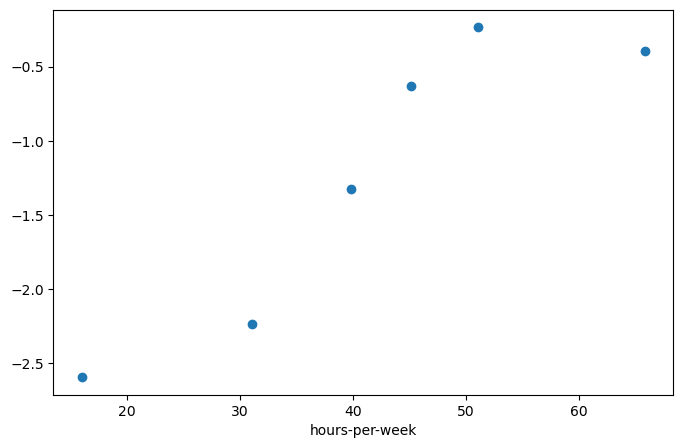

In [ ]:
# Finding Log Odds for Label/Target

for col in int_colnames:
    temp = pd.DataFrame({col: X[col], 'target': y['income']})
    temp['bin'] = pd.qcut(temp[col], q = 10, duplicates='drop')

    bin_stats = temp.groupby('bin', observed = True).agg({
        'target': 'mean', 
        col: 'mean'
    }).reset_index()

    prob = bin_stats['target'].clip(0.01, 0.99)
    log_odds = np.log(prob / (1-prob))

    plt.figure(figsize=(8,5))
    plt.scatter(bin_stats[col], log_odds)
    plt.xlabel(col)
    plt.show()



Note: Because I didn't have much time, I received aid from AI. Including, small part of code and follow up after interpretation.

Interpretation: age, education_num and hours_per_week are relatively linear, even though age and hours_per_week are some what similar to exponential graphs. I don't think it's that needed to change too much.

for capital_gain or capital_loss, I'm assuming it's because of very imbalanced data. 

for fnlwgt: I'm going to drop this column, because it's somehow collecting weight data, that's in theory not related with income.. Unless extremely tangentially. 

In [ ]:
# Dropping fnlwgt
X.drop(columns = 'fnlwgt', inplace = True)

int_colnames = int_colnames.drop('fnlwgt')

In [ ]:
int_colnames

Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

<Axes: >

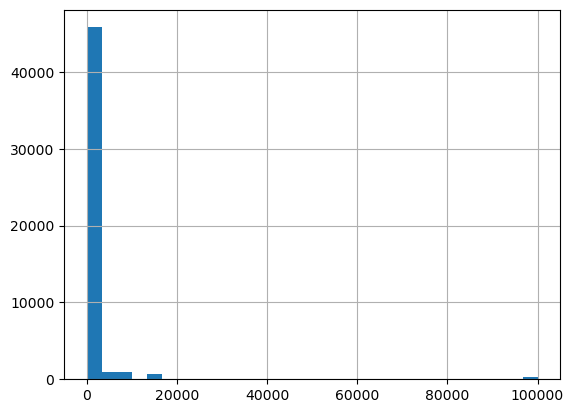

In [ ]:
X['capital-gain'].hist(bins = 30)

<Axes: >

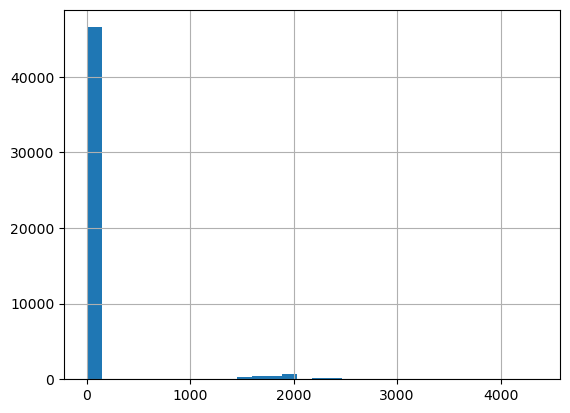

In [ ]:
X['capital-loss'].hist(bins = 30)

In [ ]:
X.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,...,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.029319,0.064207,0.000205,0.751505,0.034704,...,0.001372,0.003767,0.000430,0.002355,0.001331,0.000614,0.000553,0.914971,0.001761,0.000471
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.168701,0.245124,0.014307,0.432145,0.183030,...,0.037012,0.061263,0.020731,0.048467,0.036457,0.024776,0.023506,0.278928,0.041925,0.021695
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Interpretation: Both capital-gain and capital-loss are extremely imbalanced and are mostly at 0... all min to Q3. 
After reading around and asking AI, it seems that logistic regression can handle 0-inflated features. I thought about log-transformation and also tested, but even after log transformation, it's still very 0 inflated. 

Therefore, the assumption of linearity with log-odds of label: Check. 
(still need to learn more about this after project/semester.)

In [ ]:
# Standardizing the interger columns so that outliers won't have much effect. 
scaler = StandardScaler()
X[int_colnames] = scaler.fit_transform(X[int_colnames])

#Note: Accuracy before standardization is 0.8378

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Building Model & Evaluation

In [ ]:
lr = LogisticRegression(class_weight='balanced') # class_weight balanced because my label is somewhat imbalanced. ~75/25 split
lr.fit(x_train, y_train)

y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)

In [ ]:
feature_names = lr.feature_names_in_
coefficeints = lr.coef_[0]
coef_df = pd.DataFrame({'Features': feature_names, 'Coefficients': coefficeints, 'Absolute Coefficients': np.abs(coefficeints)}).sort_values('Absolute Coefficients', ascending = False)
coef_df.head(10)

,Features,Coefficients,Absolute Coefficients
2,capital-gain,2.315665,2.315665
14,marital-status_Married-AF-spouse,1.904701,1.904701
50,native-country_Columbia,-1.898432,1.898432
15,marital-status_Married-civ-spouse,1.653045,1.653045
28,occupation_Priv-house-serv,-1.561984,1.561984
78,native-country_Portugal,1.210185,1.210185
17,marital-status_Never-married,-1.180127,1.180127
67,native-country_Ireland,1.179023,1.179023
81,native-country_South,-0.988618,0.988618
68,native-country_Italy,0.944279,0.944279


Interpretation: These are the top ten strongest coefficients. They have strongest influence on 'Income' Label. 
For 1 unit increase in capital-gain, there will be a 2.31.. increase in Income, given that all other features are held constant. 
The positive and negative is for direction. 

In [ ]:
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy Train: {accuracy_train: .4f}")
print(f"Accuracy Test: {accuracy_test: .4f}")

Accuracy Train:  0.8074
Accuracy Test:  0.8045


Interpretation: Model generalises well without overfitting. 

In [ ]:
precision_test = precision_score(y_test, y_pred_test, average='binary')
precesion_train = precision_score(y_train, y_pred_train, average='binary')
print(f"Precision Train: {precesion_train: .4f}")
print(f"Precision Test: {precision_test: .4f}")

Precision Train:  0.5644
Precision Test:  0.5632


Interpretation: Model is catching ~56% in both train and test data, which is pretty consisent, but not high precision. It's overpredicting for positive.

In [ ]:
recall_train = recall_score(y_train, y_pred_train, average='binary')
recall_test = recall_score(y_test, y_pred_test, average='binary')
print(f"Recall Train: {recall_train:.4f}")
print(f"Recall Test: {recall_test:.4f}")

Recall Train: 0.8495
Recall Test: 0.8416


Interpretation: The model is catching around 84% of actual positives. That' good. It's catching people with income >50K well.

In [ ]:
f1_train = f1_score(y_train, y_pred_train, average='binary')
f1_test = f1_score(y_test, y_pred_test, average='binary')
print(f"F1 Train: {f1_train:.4f}")
print(f"F1 Test: {f1_test:.4f}")

F1 Train: 0.6782
F1 Test: 0.6748


Interpretation: The balance between precision and Recall is 67%. This is moderate. 

In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"Train - True Negatives (TN): {cm_train[0,0]}")
print(f"Train - False Positives (FP): {cm_train[0,1]}")
print(f"Train - False Negatives (FN): {cm_train[1,0]}")
print(f"Train - True Positives (TP): {cm_train[1,1]} \n")

print(f"Test - True Negatives (TN): {cm_test[0,0]}")
print(f"Test - False Positives (FP): {cm_test[0,1]}")
print(f"Test - False Negatives (FN): {cm_test[1,0]}")
print(f"Test - True Positives (TP): {cm_test[1,1]}")

Train - True Negatives (TN): 23621
Train - False Positives (FP): 6120
Train - False Negatives (FN): 1404
Train - True Positives (TP): 7928 

Test - True Negatives (TN): 5877
Test - False Positives (FP): 1537
Test - False Negatives (FN): 373
Test - True Positives (TP): 1982


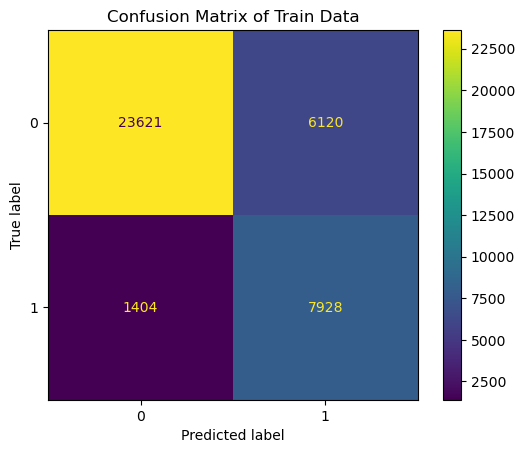

In [ ]:
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=lr.classes_)
disp_train.plot()
plt.title('Confusion Matrix of Train Data')
plt.show()

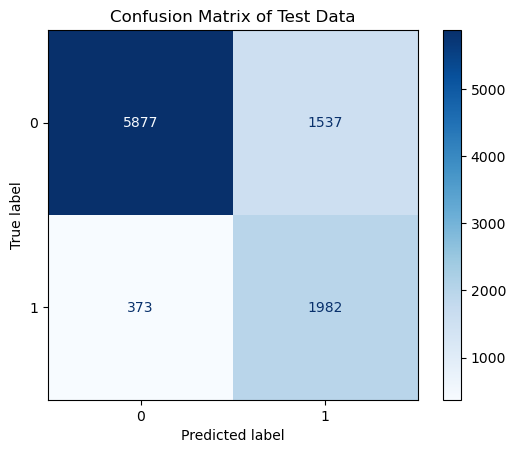

In [ ]:
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp_test.plot(cmap = 'Blues')
plt.title('Confusion Matrix of Test Data')
plt.show()